## Imports

In [95]:
from nb_utils import set_root

PROJECT_DIR = set_root(3)
print("PROJECT_DIR: " + str(PROJECT_DIR))

PROJECT_DIR: /home/manuel/Documents/projects/libs/mlpr


In [96]:
from typing import Dict, Any, Tuple, Type
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, get_scorer

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from mlpr.ml.supervisioned.regression import metrics, plots
from mlpr.ml.tunning.grid_search import GridSearch
from mlpr.reports.create import ReportGenerator
from utils.reader import read_file_yaml

import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from sklearn.base import BaseEstimator, RegressorMixin


%reload_ext autoreload

## Methods

In [97]:
class TimeSeriesGridSearch(GridSearch):
    def __init__(
        self,
        X: np.ndarray,
        y: np.ndarray,
        models_params: Dict[Type[BaseEstimator], Dict[str, Any]],
        params_split: Dict[str, Any],
        normalize: bool = False,
        params_norm: Dict[str, Any] = {},
        scoring: str = 'neg_mean_squared_error'
    ):
        super().__init__(X, y, models_params, params_split, normalize, params_norm, scoring)

    def split_data(
        self, X: np.ndarray, y: np.ndarray, **kwargs
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """
        Split data into training and test sets.

        Parameters
        ----------
        X : np.ndarray
            Features matrix.
        y : np.ndarray
            Target vector.

        Returns
        -------
        tuple
            Training and test sets.
        """
        split_index = int((1 - kwargs["test_size"]) * len(X))
        return X[:split_index], X[split_index:], y[:split_index], y[split_index:]

    def evaluate_model(self, model: BaseEstimator, params: Dict[str, Any], **kwargs):
        """
        Evaluate a model.

        Parameters
        ----------
        model : BaseEstimator
            Model to evaluate.
        params : dict
            Parameters to search.
        """
        tscv = TimeSeriesSplit(n_splits=5)
        grid = GridSearchCV(model(), params, cv=tscv, scoring=self.scoring, **kwargs)
        grid.fit(self.X_train, self.y_train)

        if self.scoring == 'neg_mean_squared_error':
            y_pred = grid.predict(self.X_test)
            score = np.sqrt(mean_squared_error(self.y_test, y_pred))
        else:
            score = grid.best_score_

        if (get_scorer(self.scoring)._sign == 1 and score < self.best_score_) or (get_scorer(self.scoring)._sign == -1 and score > self.best_score_):
            self.best_score_ = score
            self.best_model = grid.best_estimator_  # store the trained model
            self.best_params = grid.best_params_

        return self
    
class ARIMAWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, order=(1, 0, 0)):
        self.order = order
        self.model = None

    def fit(self, X: any, y: any):
        self.model = ARIMA(y, order=self.order).fit()
        return self

    def predict(self, X):
        return self.model.predict(start=X.index[0], end=X.index[-1])

## Parameters

In [98]:
path_data = PROJECT_DIR / 'data'
path_conf = PROJECT_DIR / 'conf'
path_templates = PROJECT_DIR / 'templates'
path_assets = PROJECT_DIR / 'assets'

path_intermediate = path_data / '02_intermediate'
path_models = path_data / '04_models'
path_reports = path_data / '05_reports'

path_reports_regression = path_templates / "regression"
file_path_reports = path_reports / "report_model.html"

parameters = read_file_yaml(path_conf / 'params.yaml')

datasets = parameters["datasets"]
n_seed = parameters["experiments"]["n_seed"]
target = "target"

In [99]:
np.random.seed(n_seed)

In [100]:
params = {
    "date":{
        "start": "01/01/2018",
        "end": "01/01/2024",
        "freq": "ME"
    }
}

## Read

In [101]:
date_rng = pd.date_range(**params["date"])

values = np.random.randint(0,100,size=(len(date_rng)))

# Criando um DataFrame
data = pd.DataFrame(date_rng, columns=['date'])
data['target'] = values
data = data.set_index('date')

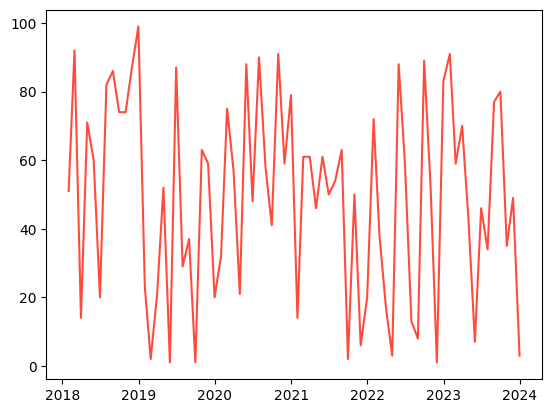

In [102]:
plt.plot(
    data.index,
    data[target]
)

## Split labels

In [103]:
# Definir o número de dias a serem usados para prever o próximo dia
look_back = 7

# Criar listas para armazenar os dados de entrada e saída
X, y = [], []

# Loop sobre o DataFrame para criar os dados de entrada e saída
for i in range(look_back, len(data)):
    X.append(data[target].values[i-look_back:i])
    y.append(data[target].values[i])

# Converter as listas em arrays numpy
X = np.array(X)
y = np.array(y)

## Modelling

In [104]:
models_params = {
    RandomForestRegressor: {
        'n_estimators': [10, 50, 100],
        'max_depth': [None, 10, 20]
    },
    LinearRegression: {
        'n_jobs': [-1]
    }
}

# Crie uma instância da classe TimeSeriesGridSearch
grid_search = TimeSeriesGridSearch(X, y, models_params, params_split={'test_size': 0.2})

# Realize a pesquisa em grade
grid_search.search()

# Obtenha o melhor modelo e seus parâmetros
best_model, best_params = grid_search.get_best_model()

## Predictions

In [88]:
data_train = pd.DataFrame(
    grid_search.X_train
)
data_train["y_true"] = grid_search.y_train
data_train["y_pred"] = grid_search.best_model.predict(grid_search.X_train)

## Metrics

In [90]:
k = 3
rm = metrics.RegressionMetrics(data_train, *["y_true", "y_pred"])

In [91]:
results = rm.calculate_metrics(
    ["mape", "rmse", "kolmogorov_smirnov", "confusion_matrix", "calculate_kappa"],
    {
        "mape": {},
        "rmse": {},
        "kolmogorov_smirnov": {},
        "confusion_matrix": {"n_bins": k},
        "calculate_kappa": {"n_bins": k}
    }
)

## Plots

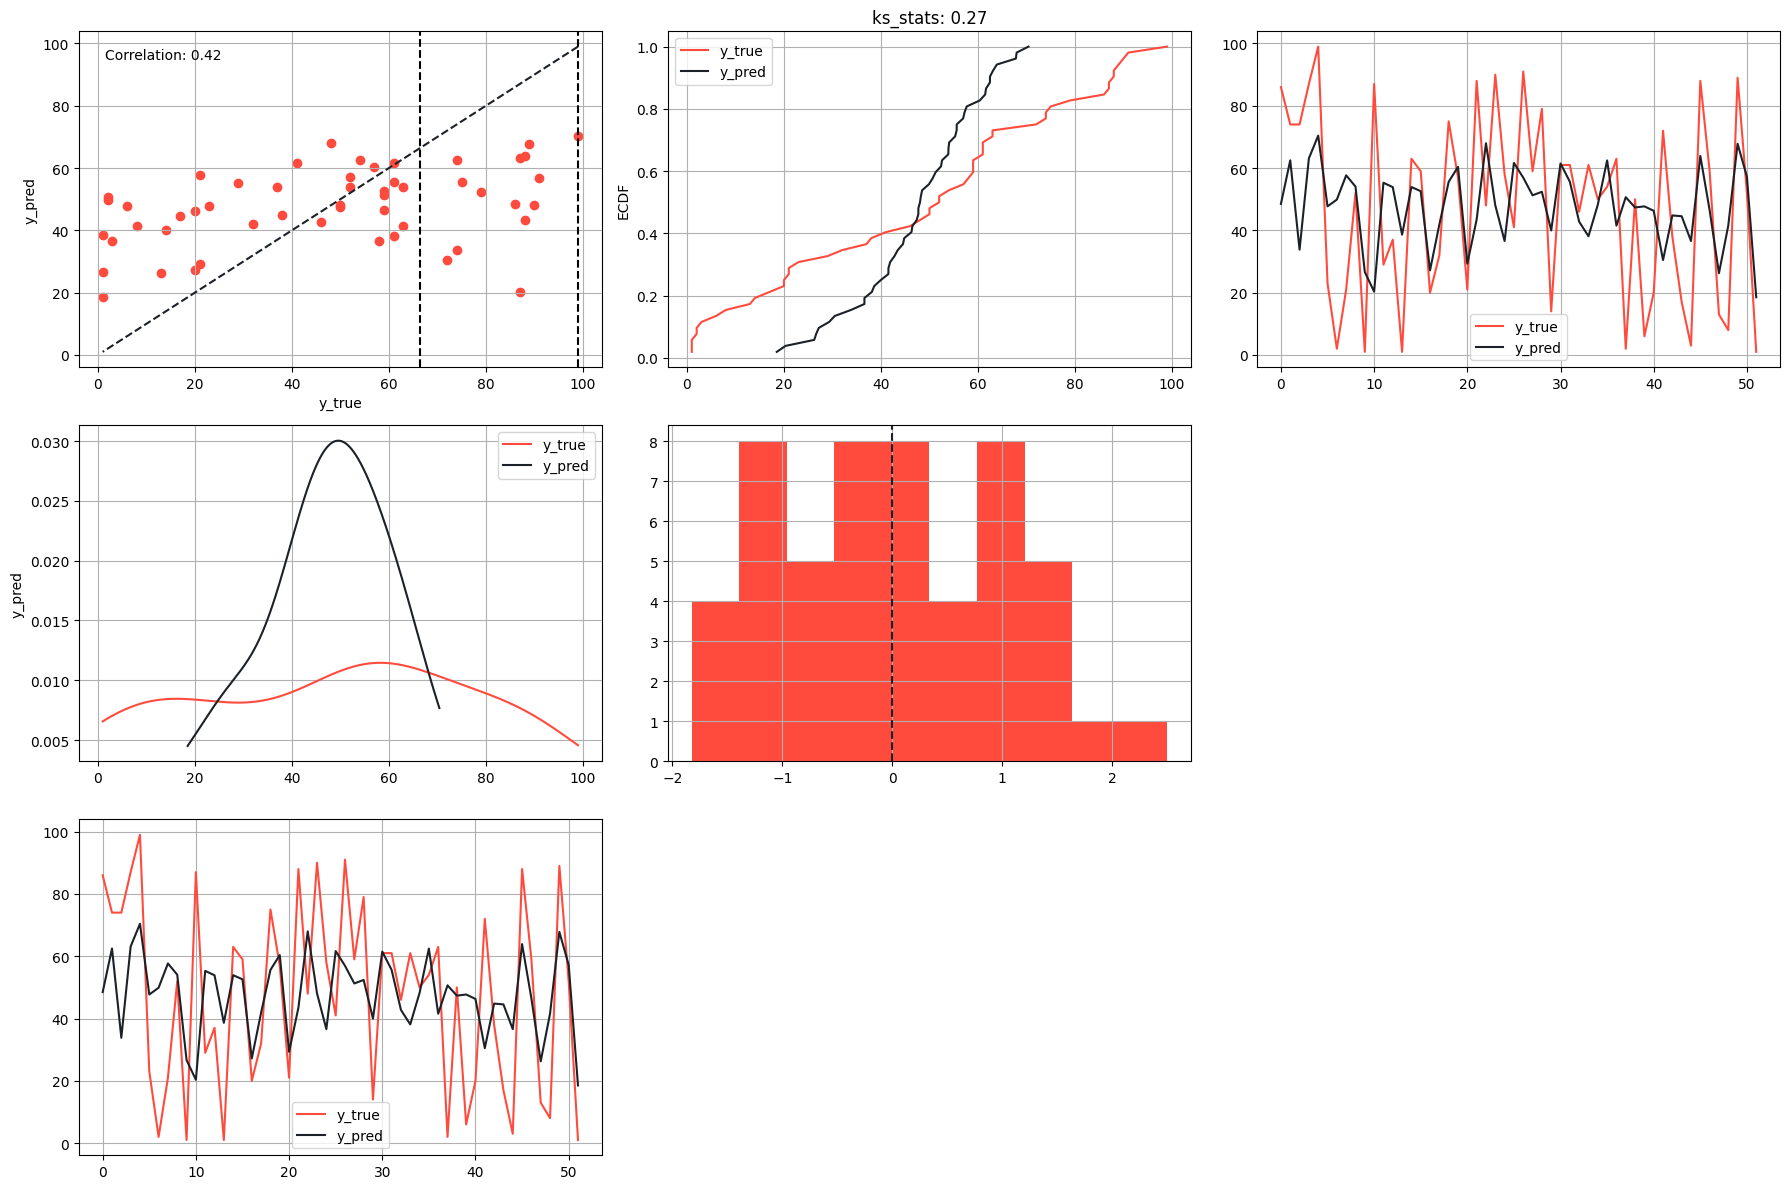

In [93]:
rp = plots.RegressionPlots(data_train, color_palette=["#FF4B3E", "#1C2127"])
fig, axs = rp.grid_plot(
    plot_functions=[
        ['graph11', 'graph12', 'graph13'],
        #['', 'graph12', ''],
        ['graph21', 'graph22'],
        #['', 'graph12', '']
        ['graph23']
    ],
    plot_args={
        'graph11': {
            "plot": "scatter",
            "params": {
                'y_true_col': 'y_true',
                'y_pred_col': 'y_pred',
                'linecolor': '#1C2127',
                'worst_interval': True,
                'metrics': rm.metrics["calculate_kappa"],
                'class_interval': rm._class_intervals,
                'method': 'recall',
                'positive': True
            }
        },
        'graph12': {
            "plot": "plot_ecdf",
            "params": {
                'y_true_col': 'y_true',
                'y_pred_col': 'y_pred'
            }
        },
        'graph21': {
            "plot": "plot_kde",
            "params": {
                'columns': ['y_true', 'y_pred']
            }
        },
        'graph22': {
            "plot": "plot_error_hist",
            "params": {
                'y_true_col': 'y_true',
                'y_pred_col': 'y_pred',
                'linecolor': '#1C2127'
            }
        },
        'graph13': {
            "plot": "plot_fitted",
            "params": {
                'y_true_col': 'y_true',
                'y_pred_col': 'y_pred',
                'condition': None,
                'sample_size': None
            }
        },
        'graph23': {
            "plot": "plot_fitted",
            "params": {
                'y_true_col': 'y_true',
                'y_pred_col': 'y_pred',
                'condition': None,
                'sample_size': None
            }
        },
    },
    show_inline=True
)

## Save image

In [17]:
fig.savefig(
    path_assets / "regression_plots.png",
    dpi=400,
    bbox_inches='tight'
)

## Reports

In [23]:
report = ReportGenerator(template_dir=path_reports_regression)
report.render(
    metrics=results,
    template_file="template_v3.html",
    output_file=file_path_reports,
    image_path=path_intermediate / "regression_plots.png"
)

'Report created successfully.'